In [1]:
from boosted_lorenzetti.dataset import aod
from boosted_lorenzetti.utils import set_logger
import boosted_lorenzetti.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import ROOT
import logging
import duckdb

/home/lucasbanunes/miniconda3/envs/blzt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ATLAS)
set_logger()
mpl.rc('text', usetex = True)

In [3]:
data_dir = Path.home() / 'data'
datasets = [
    {
        'filepath':(data_dir /
                   'lorenzetti' /
                   'v2.2.0' /
                   'user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k.avgmu250_sigmamu50_stage_3.result.AOD.duckdb'),
        'color': 'blue',
        'label': '$Z \\to ee + <\\mu> = 250$',
    }
]

# Particle $E_T$ and cluster $E_T$ ratio distribution

In [4]:
PARTICLE_ENERGY_CLUSTER_ENERGY_RATIO_QUERY = """
SELECT 
    c.id as cluster_id,
    COUNT(DISTINCT(c.id)) as n_clusters,
    MAX(c.et) as cl_et,
    MAX(c.e) as cl_e,
--    LIST(
--        STRUCT_PACK(
--            id := s.id
--        )
--    ) as seeds,
    COUNT(DISTINCT(s.id)) as n_seeds,
--    LIST(
--        STRUCT_PACK(
--            id := tp.id,
--            et := tp.et,
--            eta := tp.eta,
--            phi := tp.phi,
--            in_deta := abs(tp.eta-c.eta) < c.deta,
--            in_dphi := abs(tp.phi-c.phi) < c.dphi
--        )
--    ) as truth_particles,
    COUNT(DISTINCT(tp.id)) as n_particles,
    SUM((abs(tp.eta-c.eta) < c.deta) and (abs(tp.phi-c.phi) < c.dphi)) as in_cluster,
    -- Multiplying because particle et is in GeV
    SUM(tp.et) * 1000 as total_tp_et,
    total_tp_et/cl_et as total_tp_et_cl_et_ratio,
    SUM(tp.e) * 1000 as total_tp_energy,
    total_tp_energy/cl_e as total_tp_energy_cl_e_ratio
FROM clusters as c
JOIN
    seeds as s ON c.seed_id = s.id
JOIN
    truth_particles as tp ON s.id = tp.seed_id
GROUP BY c.id HAVING n_clusters=1;
"""

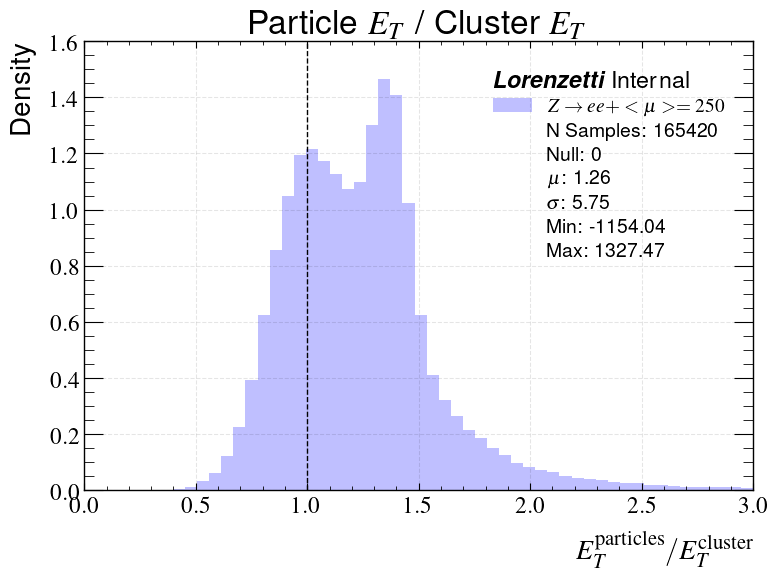

In [8]:
fig, ax = plt.subplots()
ax.grid(linestyle='--', alpha=0.1, color='k')
for ds in datasets:
    with duckdb.connect(str(ds['filepath'])) as con:
        df = con.execute(PARTICLE_ENERGY_CLUSTER_ENERGY_RATIO_QUERY).df()
    selector = (df['total_tp_et_cl_et_ratio'] > -1) & (df['total_tp_et_cl_et_ratio'] < 3)
    plotdata = df['total_tp_et_cl_et_ratio']
    ax.hist(plotdata[selector].values,
            bins=50,
            histtype='stepfilled',
            density=True,
            color=ds['color'],
            label=ds['label'],
            alpha=.25)
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {plotdata.isnull().sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
    del df
ax.axvline(1, color='k', linestyle='--', linewidth=1)
ax.set(
    title=r'Particle $E_T$ / Cluster $E_T$',
    xlabel=r'$E_T^{\mathrm{particles}} / E_T^{\mathrm{cluster}}$',
    ylabel='Density'
)
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large')
)
fig.tight_layout()